Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Hung-Wei Chang"
COLLABORATORS = ""

---

<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# Assignment 7: Sensor selection for a wearable stress detector product
<img align="left" style="padding-top:10px;" src="Respiban.png">  

## Background
Long-term stress has been proven to have harmful health effects, ranging from headaches, sleeping difficulties, and even increased risk for cardiovascular diseases.  For an individual, the ability to automatically detect signs of ongoing stress can help them to seek intervention to reduce stress levels, resulting in a reduction in harmful side-effects. 

The scenario for our project is that we are working for a company interested in developing a wearable chest-strap stress detection device, which uses sensors to detect physiological signs of stress and then alerts the user so they can take proactive action to reduce stress in order to mitigate potential long-term health effects.  The objective for our project is to determine which sensors need to be included on the new wearable device in order to accurately detect stress.

From our interviews of domain experts, we learn that stress is a physiological response to stimulus triggered by the sympathetic nervous system.  During this response, hormones are released that lead to physiological changes such as increased respiratory rate, increased heart rate, muscle tension, and increased motion.  In order to build our model, we develop a list of possible physiological and motion signals which can be feasibly measured by sensors on a non-invasive wearable device:  
- Motion/acceleration
- Electrocardiography
- Electrodermal activity
- Electromyography
- Respiration
- Skin temperature

## Data

To assist in our project, we will use data which is adapted (modified for purposes of this exercise) from the Wearable Stress and Affect Detection (WESAD) study done by engineers at Bosch which includes high-resolution data from several sensors together with labels of the subject's mood at each point in time over the duration of the study period.  The sensors are contained on two devices - one chest-based and the other wrist-based.  The description of the data in the study is below.  The study contains data on several participants - we will use the data for just one individual (S2) from the RespiBAN chest sensor array.

**Description of the dataset:**  
The study authors used the RespiBAN chest sensor to measure physiological signals and motion: http://www.biosignalsplux.com/en/respiban-professional. All signals were sampled at 700 Hz. Raw data is contained in SX_respiban.txt (where 'X' represents the patient number, e.g. 'S2_respiban.txt' for patient #2.). There are 10 columns here. First column: sequential line number. Second column: ignore. Columns 3-10: raw data of the 8 sensor channels. The order of the channels is defined in the header. The entries “XYZ” refer to the 3-channel accelerometer (thus, acceleration data is provided in 3 columns). In order to convert the raw sensor values into SI units, each signal has to be transformed based on the formulas given below ('signal' contains the raw sensor values, vcc=3, chan_bit=2^16).
- ECG (mV): `(signal/chan_bit-0.5)*vcc` Details: http://www.biosignalsplux.com/datasheets/ECG_Sensor_Datasheet.pdf
- EDA (μS): `((signal/chan_bit)*vcc)/0.12` Details: http://www.biosignalsplux.com/datasheets/EDA_Sensor_Datasheet.pdf
- EMG (mV): `(signal/chan_bit-0.5)*vcc` Details: http://www.biosignalsplux.com/datasheets/EMG_Sensor_Datasheet.pdf
- TEMP (°C):  
    vout = `signal*vcc/chan_bit`  
    rntc = `((10^4)*vout)/(vcc-vout)`  
    TEMP = `- 273.15 + 1./(1.12764514*10^(-3) + 2.34282709*10^(-4)*log(rntc) + 8.77303013*10^(-8)*(log(rntc))^3)`  
    Details: http://www.biosignalsplux.com/datasheets/TMP_Sensor_Datasheet.pdf
- XYZ (g): `(signal-Cmin)/(Cmax-Cmin)*2 - 1`, where Cmin = 28000 and Cmax = 38000  
Details: http://www.biosignalsplux.com/datasheets/ACC_Sensor_Datasheet.pdf
- RESPIRATION (%): `(signal/chan_bit - 0.5) * 100` Details: http://www.biosignalsplux.com/datasheets/PZT_Sensor_Datasheet.pdf

**Reference publication:**  
Philip Schmidt, Attila Reiss, Robert Duerichen, Claus Marberger and Kristof Van Laerhoven. 2018. Introducing WESAD, a multimodal dataset for Wearable Stress and Affect Detection. In 2018 International Conference on Multimodal Interaction (ICMI ’18), October 16–20, 2018, Boulder, CO, USA. ACM, New York, NY, USA, 9 pages. https://doi.org/10.1145/3242969.3242985

Originial (unadjusted) dataset can be found at https://ubicomp.eti.uni-siegen.de/home/datasets/icmi18/. The dataset used in this exercise has been adapted from the original to facilitate the learning objectives of this exercise.

In [2]:
# Run this before any other code cell
# This downloads the csv data files into the same directory where you have saved this notebook

import urllib.request
from pathlib import Path
import os
path = Path()

# Dictionary of file names and download links
files = {'S2_respiban_adjusted.txt':'https://storage.googleapis.com/aipi_datasets/S2_respiban_adjusted.txt',
        'S2_labels.csv':'https://storage.googleapis.com/aipi_datasets/S2_labels.csv'}

# Download each file
for key,value in files.items():
    filename = path/key
    url = value
    # If the file does not already exist in the directory, download it
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url,filename)

In [3]:
# Import needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm
from statsmodels.formula.api import ols

import warnings
warnings.filterwarnings("ignore")

## Load data

In [4]:
# Read in the raw data from the txt file
raw_data = pd.read_csv('S2_respiban_adjusted.txt',sep = '\t',skiprows=3,header=None,)

chest_data = raw_data.copy() # Work with a copy to preserve the raw dataframe

# We can delete columns 0,1,10 per the data description
chest_data = chest_data.iloc[:,2:10]
chest_data.head()

,2,3,4,5,6,7,8,9
0,31053.0,14694.0,32651.0,29553.0,37415.0,32324.0,31659.0,31364.0
1,30861.0,14680.0,32983.0,29556.0,37417.0,32333.0,31663.0,31379.0
2,30644.0,14684.0,32823.0,29561.0,37409.0,32340.0,31655.0,31367.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,30103.0,14684.0,32794.0,29561.0,37409.0,32342.0,31681.0,31365.0


In [5]:
# Read in the metadata
with open('S2_respiban_adjusted.txt') as f:
    lines = f.readlines()
metadata = lines[1]
metadata

'# {"00:07:80:D8:AB:58": {"sensor": ["ECG", "EDA", "EMG", "TEMP", "XYZ1", "XYZ2", "XYZ3", "RESPIRATION"], "device name": "RespiBan", "column": ["nSeq", "DI", "CH1", "CH2", "CH3", "CH4", "CH5", "CH6", "CH7", "CH8"], "sync interval": 2, "time": "9:39:1.0", "comments": "", "device connection": "BTH00:07:80:D8:AB:58", "channels": [1, 2, 3, 4, 5, 6, 7, 8], "date": "2017-5-22", "mode": 0, "digital IO": [0, 1], "firmware version": 770, "device": "biosignalsplux", "position": 0, "sampling rate": 700, "label": ["CH1", "CH2", "CH3", "CH4", "CH5", "CH6", "CH7", "CH8"], "resolution": [16, 16, 16, 16, 16, 16, 16, 16], "special": [{}, {}, {}, {}, {}, {}, {}, {}]}}\n'

### Question 1
Complete the below function `create_df()` which takes the raw data dataframe (`chest_data`) and the metadata string (`metadata`) as input and performs the following:  
- Adds the column names to the dataframe (`chest_data`).  The column names can be extracted from the metadata - they are contained in a list with the key "sensor" in the metadata dictionary (e.g. "ECG","EDA" etc).  Please extract them using Python, rather than manually typing them in, and ensure you remove all punctuation and white space from them, including quotation signs around them.  
- Convert the dataframe index to a timedelta index with the units as seconds.  As per the data description above, the chest sensor and label data is sampled at 700 Hz

Your function should return the dataframe with the above two changes.

In [6]:
def create_df(raw_data,meta_data):
    # YOUR CODE HERE
    import numpy as np 
    dic = dict(eval(meta_data.strip('#').strip('\n').strip("' ")))
    colnames = dic[ list(dic.keys())[0]  ]['sensor']
    raw_data.columns = colnames
    ind = np.arange(0, len(raw_data)/700 , 1/700)# raw_data.index = pd.to_timedelta(raw_data.index, unit='s' )
    raw_data.index = ind
    raw_data.index = pd.to_timedelta(raw_data.index, unit='s')
    return raw_data
    raise NotImplementedError()

In [7]:
df = create_df(chest_data.copy(),metadata)
assert set(df.columns) == set(['ECG', 'EDA', 'EMG', 'TEMP', 'XYZ1', 'XYZ2', 'XYZ3', 'RESPIRATION'])
assert np.round(np.max(df.index.total_seconds())/60,1)==105.8

Let's now read in our mood label data.  Run the cell below to read in the labels and organize them in a dictionary.  The dictionary contains the start and end time in minutes for each label (labels are contained in order as a list with the key 'ORDER').

In [8]:
# Read in the labels csv to a dictionary containing label and start and end time for each
labels = {}
with open('S2_labels.csv') as f:
    lines = f.readlines()
for line in lines[1:]:
    key = line.split(';')[0].strip('# ')
    values = [line.strip() for line in line.split(';')[1:]]
    labels[key] = values
# Convert start and end times to float
labels['START'] = [float(x) for x in labels['START']]
labels['END'] = [float(x) for x in labels['END']]
labels

{'ORDER': ['Baseline', 'Stressed', 'Meditation', 'Amusement', 'Meditation'],
 'START': [7.08, 39.55, 70.19, 81.25, 93.38],
 'END': [20.0, 50.3, 77.1, 87.47, 100.15]}

### Question 2
Complete the below function `add_labels()` which takes the dataframe output from your `create_df()` function and the dictionary containing the labels (`labels`) as inputs.  The function should add a new column to your dataframe named 'label' which contains the corresponding mood label for each point in time.  After you have added the labels, filter your dataframe to remove any observations where there is no label.  Your function should return the dataframe with the above changes.

In [9]:
def add_labels(df,label_dict): 
    # YOUR CODE HERE
    for i in range(0, len(label_dict['ORDER'])):
        condition = ( (df.index)  <= pd.Timedelta(label_dict['END'][i], unit= 'm') ) & ( df.index >= pd.Timedelta( label_dict['START'][i], unit = 'm' ))
        df.loc[condition, 'label'] = label_dict['ORDER'][i]
    df = df[~df['label'].isnull() ]
    return df
    raise NotImplementedError()

In [10]:
# Test cell for add_labels()
df_wlabels = add_labels(df.copy(),labels)
assert 'label' in list(df_wlabels.columns)
assert df_wlabels.shape==(1829945, 9)
df_wlabels.head()

,ECG,EDA,EMG,TEMP,XYZ1,XYZ2,XYZ3,RESPIRATION,label
00:07:04.800000,34209.0,15119.0,32857.0,29997.0,37367.0,31915.0,31764.0,34255.0,Baseline
00:07:04.801428,34261.0,15197.0,32658.0,30001.0,37368.0,31909.0,31757.0,34253.0,Baseline
00:07:04.802857,34323.0,15119.0,32732.0,29999.0,37359.0,31915.0,31753.0,34064.0,Baseline
00:07:04.804285,34325.0,15194.0,32645.0,30017.0,37351.0,31924.0,31744.0,34276.0,Baseline
00:07:04.805714,34307.0,15119.0,32627.0,29999.0,37351.0,31909.0,31733.0,34259.0,Baseline


## Clean up data

### Question 3
Complete the below function `unitize()` which takes as input the dataframe output from your `add_labels()` function and values for vcc, chan_bit, Cmax, Cmin (see sensor datasheet links above for details).  The function should do the following:  
- Use the transfer function equations given in the sensor spec sheets (and the description above in the Data section) to convert the raw values into the proper units for ALL sensors in the input dataframe.  As an example, the calculation for temperature conversion is provided.  
- After converting to units, combine the three components of acceleration to get one acceleration factor with the total magnitude of acceleration (take the square root of the sum of squared components of acceleration).

Your function should return a dataframe which contains the following columns: ['ECG','EDA','EMG','TEMP','RESPIRATION','ACC','label'] (the order of columns does not matter).

In [11]:
def unitize(df, vcc, chan_bit, Cmax, Cmin):
    import numpy as np 
    df_units = df.copy()
        
    # Temp calculation as an example
    vout = df['TEMP']*vcc/(chan_bit)
    rntc = 10**4*vout/(vcc-vout)
    df_units['TEMP'] = -273.15 + 1./(1.12764514*(10**(-3)) + 2.34282709*10**(-4)*np.log(rntc) + 8.77303013*10**(-8)*(np.log(rntc))**3)
        
    # YOUR CODE HERE
    df_units['ECG'] = (df['ECG']/chan_bit-0.5)*vcc
    df_units['EDA'] =  ((df['EDA']/chan_bit)*vcc)/0.12
    df_units['EMG'] = (df['EMG']/chan_bit-0.5)*vcc
    df_units['RESPIRATION'] = (df['RESPIRATION']/chan_bit - 0.5) * 100
    
    df_units[['XYZ1', 'XYZ2', 'XYZ3']] = df_units[['XYZ1', 'XYZ2', 'XYZ3']].apply(lambda x: (x-Cmin)/(Cmax-Cmin)*2 - 1)
    
    df_units['ACC'] = np.sqrt( df_units['XYZ1'] **2 + df_units['XYZ2']**2 + df_units['XYZ3']**2 )  
    df_units = df_units[ ['ECG','EDA','EMG','TEMP','RESPIRATION','ACC','label']  ]
    return df_units
    raise NotImplementedError()

# ECG (mV): (signal/chan_bit-0.5)*vcc Details: http://www.biosignalsplux.com/datasheets/ECG_Sensor_Datasheet.pdf
# EDA (μS): ((signal/chan_bit)*vcc)/0.12 Details: http://www.biosignalsplux.com/datasheets/EDA_Sensor_Datasheet.pdf
# EMG (mV): (signal/chan_bit-0.5)*vcc Details: http://www.biosignalsplux.com/datasheets/EMG_Sensor_Datasheet.pdf
# TEMP (°C):
# vout = signal*vcc/chan_bit
# rntc = ((10^4)*vout)/(vcc-vout)
# TEMP = - 273.15 + 1./(1.12764514*10^(-3) + 2.34282709*10^(-4)*log(rntc) + 8.77303013*10^(-8)*(log(rntc))^3)
# Details: http://www.biosignalsplux.com/datasheets/TMP_Sensor_Datasheet.pdf
# XYZ (g): (signal-Cmin)/(Cmax-Cmin)*2 - 1, where Cmin = 28000 and Cmax = 38000
# Details: http://www.biosignalsplux.com/datasheets/ACC_Sensor_Datasheet.pdf
# RESPIRATION (%): (signal/chan_bit - 0.5) * 100 Details: http://www.biosignalsplux.com/datasheets/PZT_Sensor_Datasheet.pdf

In [12]:
# Test cell for unitize()
vcc = 3
chan_bit = 2**16
Cmax = 38000
Cmin = 28000
df_units = unitize(df_wlabels.copy(),vcc,chan_bit,Cmax,Cmin)

assert set(df_units.columns) == set(['ECG','EDA','EMG','TEMP','RESPIRATION','ACC','label'])
assert df_units.iloc[0,:].loc['label']=='Baseline'
assert np.round(df_units.iloc[0,:].loc['ACC'],2)==0.93

display(df_units.head())


,ECG,EDA,EMG,TEMP,RESPIRATION,ACC,label
00:07:04.800000,0.065964,5.767441,0.004074,28.911948,2.268982,0.933287,Baseline
00:07:04.801428,0.068344,5.797195,-0.005035,28.906209,2.265930,0.934125,Baseline
00:07:04.802857,0.071182,5.767441,-0.001648,28.909078,1.977539,0.932376,Baseline
00:07:04.804285,0.071274,5.796051,-0.005630,28.883256,2.301025,0.930946,Baseline
00:07:04.805714,0.070450,5.767441,-0.006454,28.909078,2.275085,0.932240,Baseline



### Question 4
Complete the below function `clean_data()` which takes as input the dataframe output from your `unitize()` function and a list of labels to filter on (`relevant_labels`).  The function should perform the following:  
- Filter the dataframe to only contain rows with a label included in `relevant_labels`  
- Then, fill the null signal values in the filtered dataframe using a forward-fill approach (set them equal to the last observed value in time before the null value)  

Your function should return the cleaned dataframe with rows corresponding only to the mood labels in `relevant_labels` and no null values

In [13]:
def clean_data(df, relevant_labels):
    # YOUR CODE HERE
    df_filter = df.copy()
    df_filter = df_filter[df_filter['label'].isin(relevant_labels)]
    df_filter = df_filter.ffill(axis = 0)
    return df_filter
    raise NotImplementedError()

In [14]:
relevant_labels=['Baseline','Stressed','Amusement']
chest_data_clean = clean_data(df_units.copy(),relevant_labels)
assert set(chest_data_clean['label'].unique())==set(relevant_labels)


## Handle outliers
A good place to start in looking for anomalous values is by visually evaluating the data. Let's do this by creating a simple plot of each signal over the period, and observe whether we see unusual values.  Warning: we have a lot of data so these plots may take some time to generate.  If it gets stuck, don't worry about running this cell, it's not needed to answer the questions.

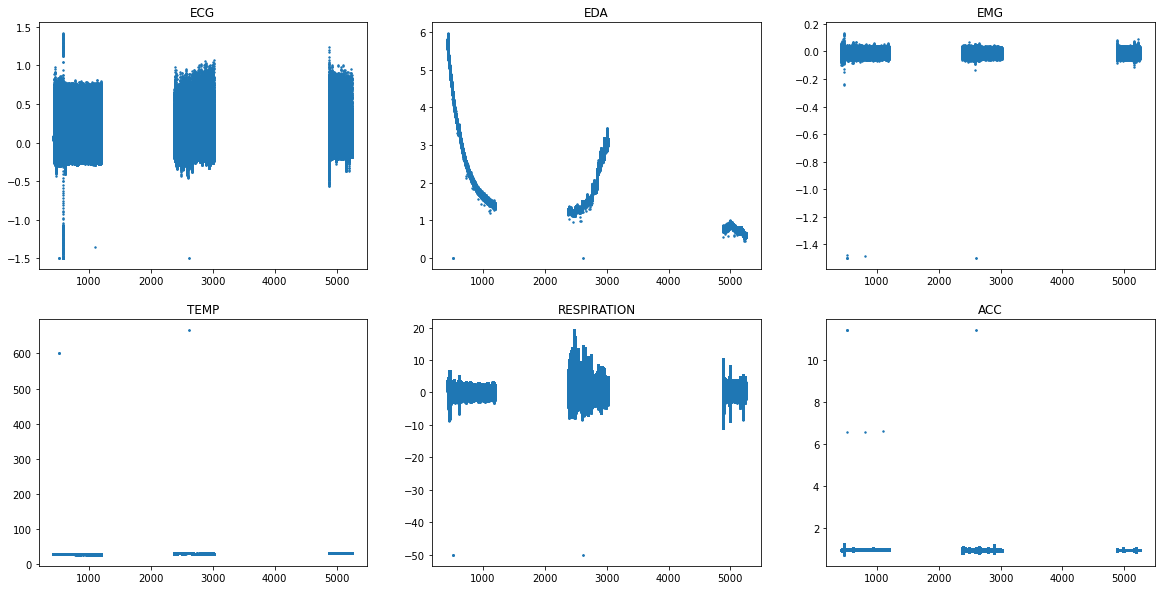

In [15]:
# Look at plots of the raw data over the study period (this may take some time to run)
# Set up grid
fig,ax = plt.subplots(2,3,figsize=(20,10))
# Make lineplots for each signal
for i,sig in enumerate(['ECG','EDA','EMG','TEMP','RESPIRATION','ACC']):
    axis=ax[i//3,i%3]
    axis.scatter(x=chest_data_clean.index.total_seconds(), y=chest_data_clean[sig],s=2)
    axis.set_title(sig)
plt.show()

### Question 5
Let's now look at a couple of statistical methods of determining if these points are outliers and likely to be anomalous.  Let's start by using the Standard Deviation method.  This method assumes that the distribution of the data is Gaussian or Gaussian-like.  We calculate the mean and standard deviation of the data, and then identify any point which falls above an upper limit or below a lower limit which are calculated as +/- k standard deviations from the mean.  A value of k=3 standard deviations is commonly used, although for large sample sizes a higher value may be used.  In this case, since we have a large number of datapoints and our goal is solely to filter out values which are almost certainly anomalous we will use a large value for k. 

Complete the below function `detect_anomalies_stdev()` which takes as input a pandas series (one column of your `chest_data_clean` dataframe at a time) and a value of k, and returns a **list** of the timedelta index values of the outlier points for that feature.  For example, if we provide as input the 'ECG' column, the function should return the timedelta index values of potential outlier points based on ECG values.

In [16]:
# Function to detect outliers from a pandas series using the standard deviation approach
def detect_anomalies_stdev(col, k):
    # YOUR CODE HERE
    col_normalized =(col-col.mean())/col.std()
    condition = ( col_normalized > k ) | (col_normalized < -k)
    outlier_list = col_normalized.loc[condition ].index.tolist()
    return outlier_list
    raise NotImplementedError()

In [17]:
# Compute and print the potential anomalous rows for each signal
all_anomalies_std = []
k = 15
for sig in ['ECG','EDA','EMG','TEMP','RESPIRATION','ACC']:
    anomalies_std = detect_anomalies_stdev(chest_data_clean[sig],k)
    all_anomalies_std += anomalies_std

# Print the set of all possible anomalous rows
all_anomalies_std = set(all_anomalies_std)
all_anomalies_std = sorted(all_anomalies_std)
assert len(set(all_anomalies_std))==11
assert all_anomalies_std[0].seconds==463

print('\nThe list of possible anomalous datapoints your function identified is:')
print(all_anomalies_std)


The list of possible anomalous datapoints your function identified is:
[Timedelta('0 days 00:07:43.552857'), Timedelta('0 days 00:07:43.554285'), Timedelta('0 days 00:08:32.908571'), Timedelta('0 days 00:08:32.910000'), Timedelta('0 days 00:08:32.911428'), Timedelta('0 days 00:08:32.912857'), Timedelta('0 days 00:08:32.914285'), Timedelta('0 days 00:13:26.302857'), Timedelta('0 days 00:18:20.398571'), Timedelta('0 days 00:43:30.710000'), Timedelta('0 days 00:43:30.711428')]


### Question 6
The above Standard Deviation Method assumes the dataset is Gaussian-like. To determine whether it is an acceptable approach to identifying outliers for our dataset, let's test the data for normality.  One way to do this is a visual test using a Q-Q plot.  In a Q-Q plot, we generate an ideal Gaussian distribution, and each data point in our sample is paired with a similar member from the idealized distribution at the same cumulative distribution. The results are plotted with the idealized distribution on the x-axis and the actual distribution on the y-axis. A perfect match to a Gaussian distribution would be a line of points at a 45-degree angle from the bottom left. Deviance from this line indicates the Gaussian assumption may not fit the data.

Complete the below function `test_normality()` which generates Q-Q plots for each signal (['ECG','EDA','EMG','TEMP','RESPIRATION','ACC']).  Run your function, analyze your plots, and then determine if the data for all signals is Gaussian-like based on visual analysis of the plots (you do not need to do any statistical tests to answer this question).  If all data appears Gaussian-like, return the boolean `True` (hard-code as `return True`).  If data for one or more signals does not appear Gaussian-like, return `False`.

Note that because we have a large number of datapoints, this may take a bit of time to run.

In [18]:
def test_normality(chest_data_clean):
    # YOUR CODE HERE
    return False 
    raise NotImplementedError()

In [19]:
# import numpy as np 
# import pylab 
# import scipy.stats as stats

# for sig in ['ECG','EDA','EMG','TEMP','RESPIRATION','ACC']:
#     data = chest_data_clean[sig]
#     stats.probplot(data, dist="norm", plot=pylab)
#     print(sig)
#     pylab.show()

In [20]:
# Test cell for test_normality()
normal = test_normality(chest_data_clean)
assert type(normal)==bool

### Question 7
Alternatively, we can detect possible anomalies using the Interquartile Range (IQR) Method.  The IQR method is often used for detecting outliers in non-Gaussian data.  The IQR is calculated as the difference between the 75th percentile and the 25th percentile in the data.  Upper and lower thresholds are typically set as `k * IQR` above and below the 75% and 25th percentiles, respectively.  Any data point that falls above the upper threshold or below the lower threshold is deemed a possible outlier.  A value of 1.5 is commonly used for k

Complete the below function `detect_anomalies_iqr()` which takes as input a pandas series (one column of your `chest_data_clean` dataframe at a time) and a value k (see above), computes the IQR and the upper and lower thresholds, and then outputs a list of the timedelta index values of any rows which are above or below the upper or lower threshold for the signal.

In [21]:
def detect_anomalies_iqr(col,k):
    # YOUR CODE HERE
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    lower_thr = Q1 - k * IQR 
    upper_thr = Q3 + k * IQR
    condition = ( col < lower_thr ) | (col > upper_thr)
    outlier_list = col.loc[condition ].index.tolist()
    return outlier_list
    raise NotImplementedError()

In [22]:
# Test cell for detect_anomalies_iqr()
all_anomalies_iqr = []
k=15 # We use a large k since the data has high variance and we are looking for extreme outliers only
for sig in ['ECG','EDA','EMG','TEMP','RESPIRATION','ACC']:
    anomalies_iqr = detect_anomalies_iqr(chest_data_clean[sig],k)
    all_anomalies_iqr += anomalies_iqr

# Print the set of all possible anomalous rows
all_anomalies_iqr = set(all_anomalies_iqr)
all_anomalies_iqr = sorted(all_anomalies_iqr)
assert len(all_anomalies_iqr)==11
assert all_anomalies_iqr[0].seconds == 463
print(f'\nThe list of all possible anomalous datapoints is:')
print(all_anomalies_iqr)


The list of all possible anomalous datapoints is:
[Timedelta('0 days 00:07:43.552857'), Timedelta('0 days 00:07:43.554285'), Timedelta('0 days 00:08:32.908571'), Timedelta('0 days 00:08:32.910000'), Timedelta('0 days 00:08:32.911428'), Timedelta('0 days 00:08:32.912857'), Timedelta('0 days 00:08:32.914285'), Timedelta('0 days 00:13:26.302857'), Timedelta('0 days 00:18:20.398571'), Timedelta('0 days 00:43:30.710000'), Timedelta('0 days 00:43:30.711428')]


### Question 8
Let's now remove the anomalous rows from our dataset which were detected using the IQR method.  Complete the function below `remove_IQR_outliers()` which returns the input dataframe with the rows containing the identified outlier values (in any column, using the IQR method) removed.

In [23]:
def remove_IQR_outliers(df):
    # YOUR CODE HERE
    # Test cell for detect_anomalies_iqr()
    all_anomalies_iqr = []
    k=15 # We use a large k since the data has high variance and we are looking for extreme outliers only
    for sig in ['ECG','EDA','EMG','TEMP','RESPIRATION','ACC']:
        anomalies_iqr = detect_anomalies_iqr(chest_data_clean[sig],k)
        all_anomalies_iqr += anomalies_iqr

    # Print the set of all possible anomalous rows
    all_anomalies_iqr = set(all_anomalies_iqr)
    all_anomalies_iqr = sorted(all_anomalies_iqr)
    
    lis = [item for item in df.index.tolist() if item not in all_anomalies_iqr]
    df_no_outliers = df.loc[ lis,:]
    
    return df_no_outliers 
    
    raise NotImplementedError()

In [24]:
# Test cell for remove_IQR_outliers()
chest_data_no_outliers = remove_IQR_outliers(chest_data_clean.copy())
rows_removed = chest_data_clean.shape[0] - chest_data_no_outliers.shape[0]
print('Your function removed {} rows'.format(rows_removed))


Your function removed 11 rows


## Analyze the data

Our data is now in proper units, filtered for modeling, and scrubbed to remove null values and anomalies.  Now we are ready to explore the data to identify trends and patterns which we can use to determine which sensors help us most in identifying periods of stress.

### Question 9
Complete the below function `signals_boxplot()`.  The function should create a boxplot of the values for each signal, so you should have 6 boxplots in total - one each for ['ECG','EDA','EMG','TEMP','RESPIRATION','ACC'].  You should group the data for each boxplot by the mood label ('Amusement','Baseline','Stressed').  

Take a look at the boxplots you have created for 'TEMP' and 'EDA'.  For each of those signals, determine visually from your boxplot (no need to calculate it) whether the median value for the 'Stressed' datapoints is higher than the median value for the 'Baseline' points.  If it is, return the boolean `True` for the signal, otherwise return `False`.  The output from your function should be two boolean values indicating whether the median of the signal is higher for the 'Stressed' datapoints relative to the baseline for 1) 'Temp' and 2) 'EDA'.  For example, if the median for both is higher, your function would return `return True, True`.

In [25]:
def signals_boxplot(df):
    # Plot box plots for each sensor type, grouped by label condition
    # YOUR CODE HERE
    return True, False 
    raise NotImplementedError()

In [26]:
# df_test = chest_data_no_outliers.copy()
# for i in ['ECG','EDA','EMG','TEMP','RESPIRATION','ACC']:
#     boxplot = df_test.boxplot(column=i, by=['label'] ,figsize=(10,5))
#     boxplot

In [27]:
temp_higher,eda_higher = signals_boxplot(chest_data_no_outliers)
assert type(temp_higher)== bool
assert type(eda_higher)== bool


### Question 10
For the signals 'EDA','TEMP' and 'RESPIRATION', let's use an ANOVA rather than rely on visual analysis to determine if the difference between the mean signal values for the groups is statistically significant at a level of alpha=0.05.

Complete the below function `anova_signals()` which takes as input the dataframe `chest_data_no_outliers` and a list of signals `signals` to evaluate.  The function should perform an ANOVA analysis on the signals in the input list `signals`.  Your function should then return a **list** containing the p-values (as floats) of the ANOVA analysis for each of the signals in `signals`.

In [28]:
def anova_signals(df,signals):
    # YOUR CODE HERE
    # Run an ANOVA analysis
    pvalues = []
    for signal in signals:
        aov_model = ols(f'{signal} ~ label',data=df).fit()
        aov_table = sm.stats.anova_lm(aov_model, typ=2)
        pvalue = aov_table.iloc[0, -1]
        pvalues.append(pvalue)
    return pvalues 
    raise NotImplementedError()

In [29]:
# Test cell for anova_signals()
signals = ['EDA','TEMP','RESPIRATION']
pvals = anova_signals(chest_data_no_outliers,signals)
assert len(pvals) == len(signals)
print('Your function calculated the following p values:')
print(pvals)

Your function calculated the following p values:
[0.0, 0.0, 2.4444459685764696e-06]


In addition to our boxplots and statistical tests of differences in mean values, it is a good idea to plot the data again - because sometimes there are other indicators we might look for in the data beyond a difference in means between groups (e.g. one group might have a much higher variance than the others, or there might be an increasing/decreasing trend in values of one group not observed in the others.  Run the below cell which plots scatterplots of the values for 'TEMP', 'EDA' and 'RESPIRATION' colored based on mood.  Take note of differences you observe in the variance or trend of the points occuring during the 'Stressed' state relative to the other mood states.  You may find better indicators here of mood than our previous analyses!

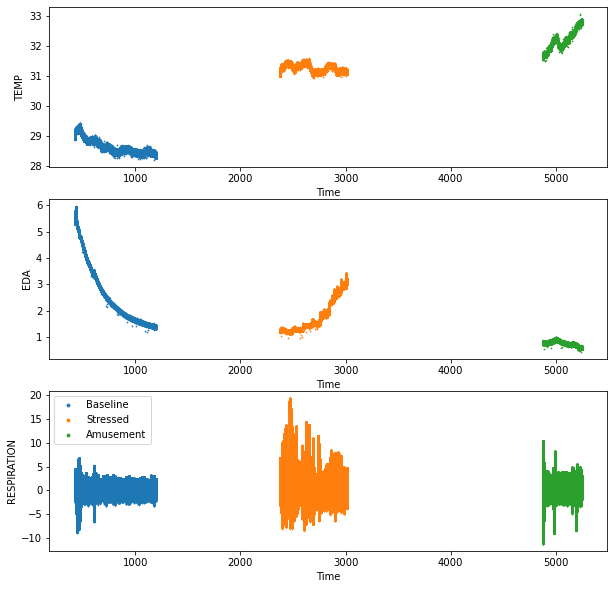

In [30]:
fig,ax = plt.subplots(3,1,figsize=(10,10))
for i,sig in enumerate(['TEMP','EDA','RESPIRATION']):
    axis=ax[i]
    for label in chest_data_no_outliers['label'].unique(): # Collect datapoints for each label group and plot on same plot
        group = chest_data_no_outliers[chest_data_no_outliers['label']==label]
        axis.scatter(group.index.total_seconds(),group[sig],s=.5,label=label)
    axis.set_xlabel('Time')
    axis.set_ylabel(sig)
plt.legend(markerscale=4)
plt.show()